<a href="https://colab.research.google.com/github/unkind58/Project_Football_Kits_Classifier/blob/main/football_kits_classifier_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

from google.colab import drive
from IPython.display import Image

Next step is setting random seed and mounting Google Drive where all images are stored

In [4]:
np.random.seed(seed=158)
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
path = Path('/content/gdrive/MyDrive/Projects/Data')
path_save = Path('/content/gdrive/MyDrive/Projects/models')

%cd /content/gdrive/MyDrive/Projects/Data

/content/gdrive/MyDrive/Projects/Data


Exploring what Data folder contains

In [6]:
!ls

'ADO Den Haag'		  'Fortuna Sittard'	  'Sunderland AFC'
'Club Atletico Aldosivi'  'Manchester United FC'  'West Bromwich Albion FC'
'FC Nantes'		  'Norwich City FC'
'FC Neman Grodno'	  'Portland Timbers'


Setting Batch Size

In [53]:
bs = 8

Creating Image Data Bunch with normalization, dividing train and validation sets as 80/20.

In [16]:
dls = ImageDataBunch.from_folder(path,train=".",valid_pct=0.2,
                                  ds_tfms=get_transforms(), 
                                  seed= 58,
                                  size=224, 
                                  num_workers=4, 
                                  bs=bs).normalize(imagenet_stats)

Classes amount, sets shapes and classes names.

In [11]:
print(f'Total training set image amount: {len(dls.train_ds)}')
print(f'Total validation set image amount: {len(dls.valid_ds)}')
print(f'Total classes number: {dls.c}')
print()
dls.classes

Total training set image amount: 196
Total validation set image amount: 48
Total classes number: 10



['ADO Den Haag',
 'Club Atletico Aldosivi',
 'FC Nantes',
 'FC Neman Grodno',
 'Fortuna Sittard',
 'Manchester United FC',
 'Norwich City FC',
 'Portland Timbers',
 'Sunderland AFC',
 'West Bromwich Albion FC']

Taking a look at a Valdiation set random Data Bunch.

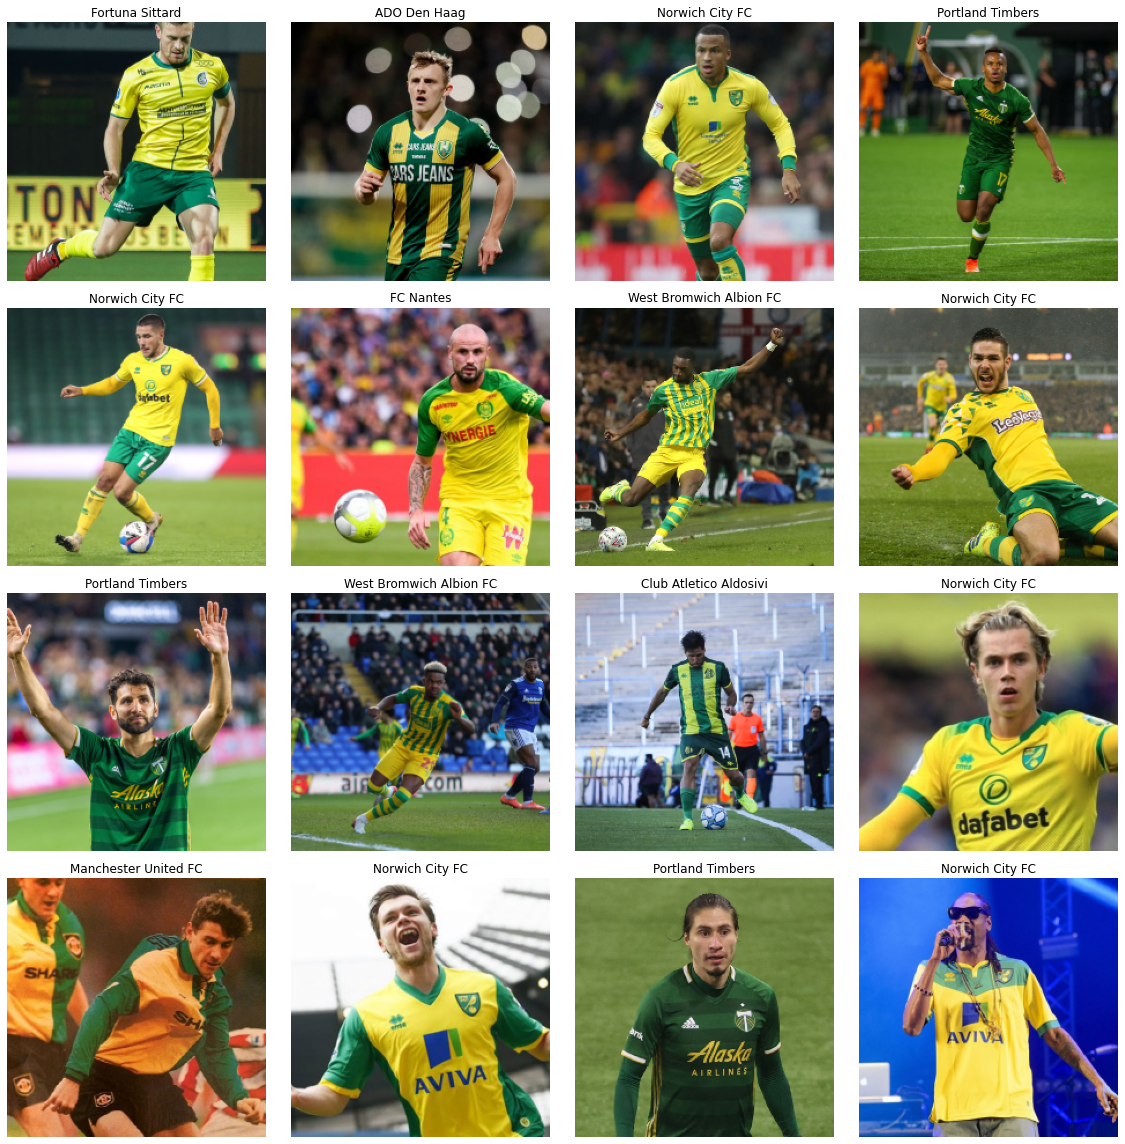

In [ ]:
dls.show_batch(ds_type=DatasetType.Valid)

Initializing Convolutional Neural Network  using transfer learning with RESNET34 as a pretrained model. Evaluation metric is error rate.

In [18]:
learn = cnn_learner(dls,models.resnet34,metrics=error_rate)

Creating new derictory for storaging models.

In [19]:
learn.model_dir='/content/gdrive/MyDrive/Projects/models'
learn.path/learn.model_dir

PosixPath('/content/gdrive/MyDrive/Projects/models')

Running 6 epochs with .fit_one_cycle() method.

In [20]:
learn.fit_one_cycle(6)

Ground truth VS. Predictions

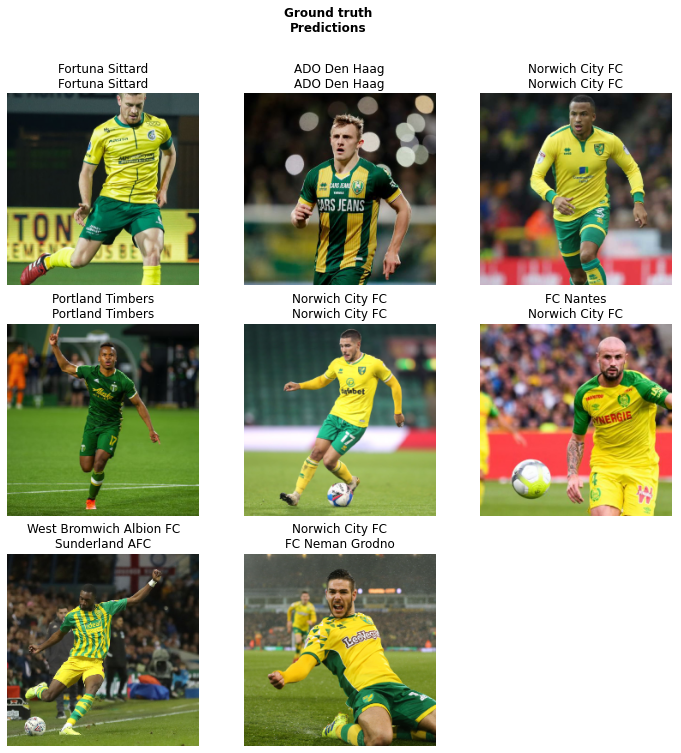

In [21]:
learn.show_results()

Saving first stage model, unfreezing last layers and finding optimal Learning rate.

In [22]:
learn.save('stage-1')

In [23]:
learn.unfreeze()

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [38]:
#  dls.valid_ds.items

Plotting Learning rate finder's computations.

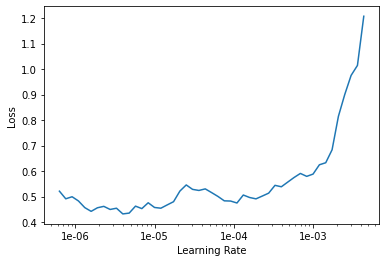

In [25]:
learn.recorder.plot()

Slicing Learning rate from 1e-5 to 3e-5.

In [26]:
learn.fit_one_cycle(5, max_lr=slice(1e-5,3e-5))

In [27]:
learn.save('stage-2')

In [28]:
interp = ClassificationInterpretation.from_learner(learn)

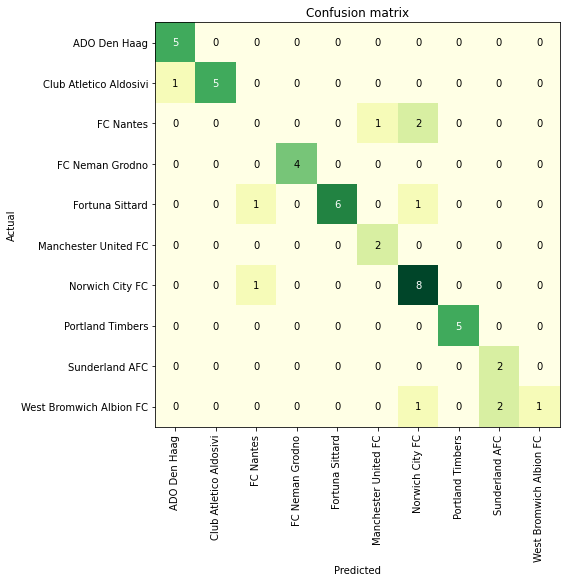

In [51]:
interp.plot_confusion_matrix(cmap='YlGn',figsize=(12,8))

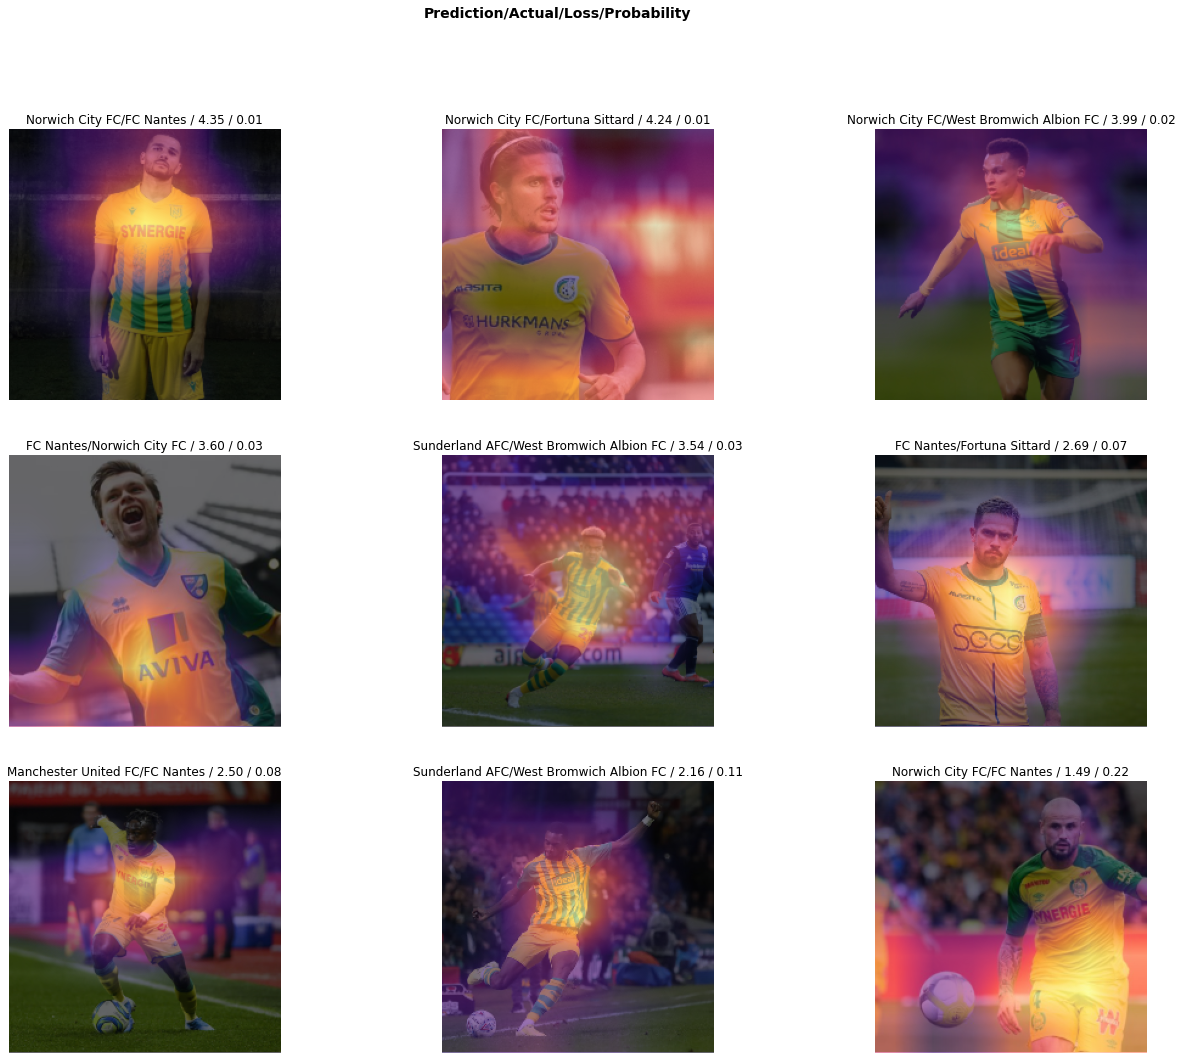

In [52]:
interp.plot_top_losses(9, figsize=(22,17),heatmap=True)

In [38]:
interp.most_confused(min_val=1)

[('FC Nantes', 'Norwich City FC', 2),
 ('West Bromwich Albion FC', 'Sunderland AFC', 2),
 ('Club Atletico Aldosivi', 'ADO Den Haag', 1),
 ('FC Nantes', 'Manchester United FC', 1),
 ('Fortuna Sittard', 'FC Nantes', 1),
 ('Fortuna Sittard', 'Norwich City FC', 1),
 ('Norwich City FC', 'FC Nantes', 1),
 ('West Bromwich Albion FC', 'Norwich City FC', 1)]

In [54]:
learn.unfreeze()

In [55]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


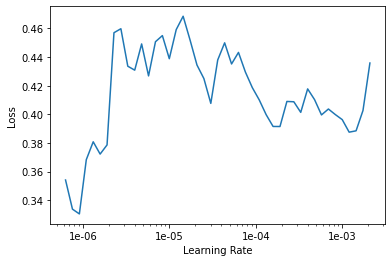

In [56]:
learn.recorder.plot()

In [57]:
learn.fit_one_cycle(5, max_lr=1e-6)

In [58]:
learn.save('stage-3')

Adding image augmentations

In [59]:
tfms = get_transforms(do_flip=False,max_rotate=10.,max_zoom=1.3,max_lighting=0.4, 
                      max_warp=0.4, p_affine=1., p_lighting=1.,)

In [69]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=58)

In [81]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_folder()).transform(tfms, size=size, padding_mode=padding_mode).databunch(bs=bs).normalize(imagenet_stats)

In [82]:
data_augm = get_data(224, bs)

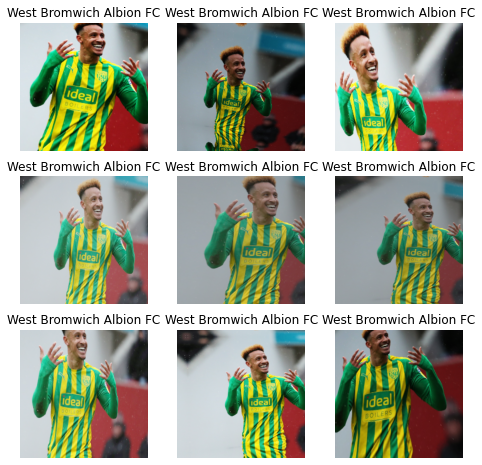

In [86]:
def _plot(i,j,ax):
    x,y = data_augm.train_ds[58]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [87]:
gc.collect()

51562

In [95]:
print(f'Total training set image amount: {len(data_augm.train_ds)}')
print(f'Total validation set image amount: {len(data_augm.valid_ds)}')

Total training set image amount: 196
Total validation set image amount: 48


In [88]:
learn = cnn_learner(data_augm, models.resnet34, metrics=error_rate)

In [89]:
learn.fit_one_cycle(5)

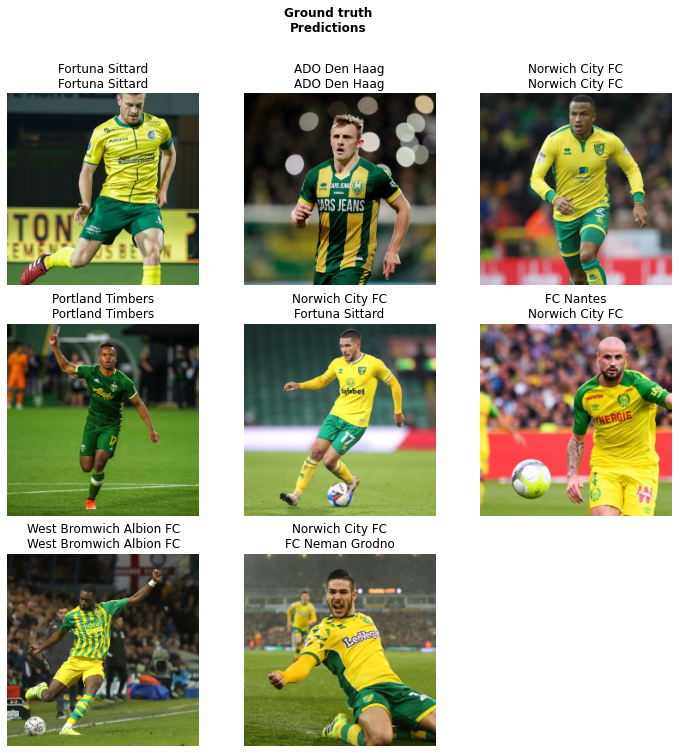

In [90]:
learn.show_results()

In [91]:
learn.unfreeze()

In [92]:
learn.fit_one_cycle(12, pct_start=0.8)

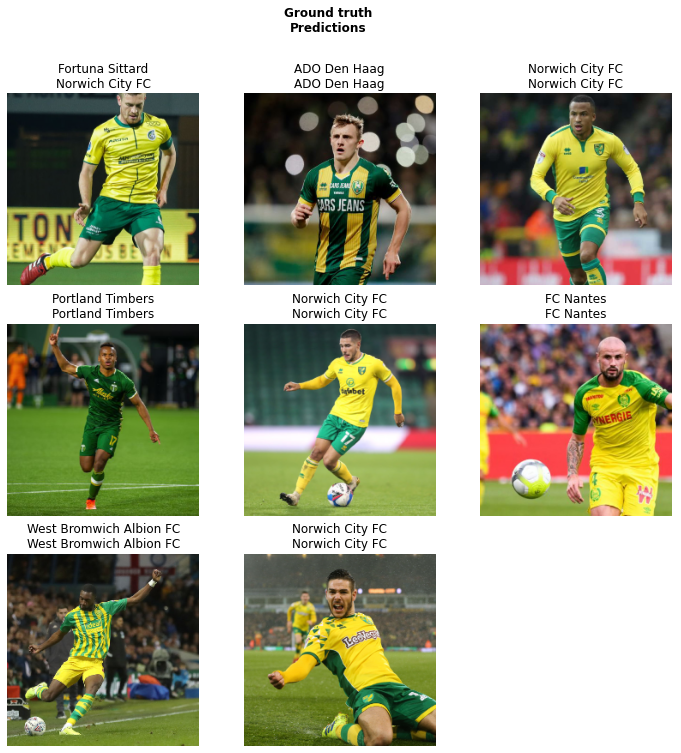

In [96]:
learn.show_results()

In [97]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


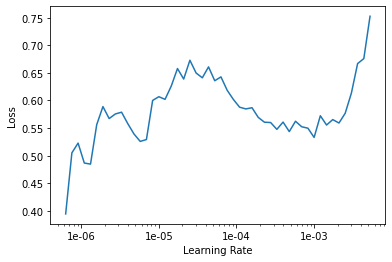

In [98]:
learn.recorder.plot()

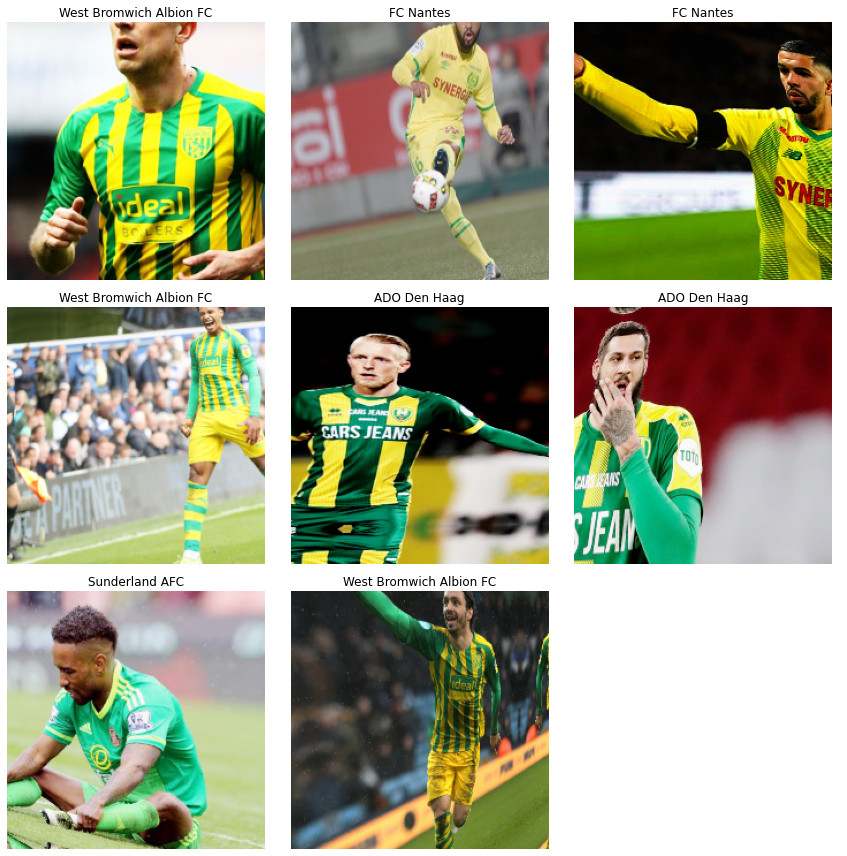

In [100]:
data_augm.show_batch(ds_type=DatasetType.Train)